# Canadian Rental Prices Data Modeling

We're going to work with the data preprocessed in [this notebook](DataPreprocessing.ipynb), which contains rental price data associated with multiple factors like the location, type of rental, number of rooms, etc. 

The price is our target variable. We're going to explore different regularized regression models before choosing a final regression model that we will use to predict new rental prices.

In [83]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [4]:
# Load data
with open('../Data/preprocessed_data.pkl', 'rb') as handle:
    data = pickle.load(handle)

city_frequency_map = data['city_frequency_map']
df = data['df']

df.shape

(18947, 6)

### Create helper functions

In [6]:
def residual_analysis_plots(model):
    '''Plots the residuals and the Q-Q Plot in the same figure'''
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15, 6))
    
    sns.scatterplot(x=model.predict(), y=model.resid, ax=ax1)
    ax1.set_title("Residual Plot")
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Residuals")
    ax1.axhline(0, linestyle="--", color="orange")

    ax2.hist(model.resid, bins=30)
    ax2.set_title("Distribution of the residuals")
    
    stats.probplot(model.resid, dist="norm", plot=ax3)
    ax3.set_title("Normal Q-Q Plot")  

    plt.tight_layout()
    plt.show()

In [7]:
def eval_performance(test, predictions):
    MAE = mean_absolute_error(test, predictions)
    MSE = mean_squared_error(test, predictions)
    RMSE = np.sqrt(MSE)
    test_mean = test.mean()
    pred_mean = predictions.mean()
    ratio = RMSE / test_mean
    
    metrics = {
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
        'RMSE to mean ratio': ratio
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)
    
    return df

In [8]:
def compare_performances(initial_perf, current_perf):
    df = pd.merge(initial_perf, current_perf, on='Metric', suffixes=['_initial', '_current'])
    df['Difference'] = df['Value_current'].astype('float') - df['Value_initial'].astype('float')
    return df

## 1. Initial regression model (linear regression)

### 1.1 Without scaling

In [11]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [13]:
# Fit model
X_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     1337.
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:51:37   Log-Likelihood:            -1.3040e+05
No. Observations:               16104   AIC:                         2.608e+05
Df Residuals:                   16098   BIC:                         2.609e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            371.7288     27.423     13.555      0.000     317.977     425.481
city               0.0433      0.004     10.833      0.000       0.035       0.051
beds             192.5569      9.140     21.068      0.000     174.642     210.472
baths            524.3523     13.820     37.942      0.000     497.264     551.441
sq_feet            0.2504      0.017     14.991      0.000       0.218       0.283
type_Apartment   588.3599     17.044     34.519      0.000     554.951     621.769
==============================================================================
Omnibus:                    19253.694   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12700491.415
Skew:                           5.737   Prob(JB):                         0.00
Kurtosis:                     140.099   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

The R-squared is 0.293, which indicates that 29.3% of the variance of the price is explained by the model, which suggests a poor fit.

Based on the p-values, all features seem to be statistically significant.

The Durbin-Watson score of 2 indicates that the errors are independent.

In [15]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_constant)
initial_performance = eval_performance(y_test, y_pred)
initial_performance

,Metric,Value
0,MAE,500.2829
1,MSE,523194.6194
2,RMSE,723.3219
3,Test Mean,2157.2931
4,Predictions Mean,2154.3472
5,RMSE to mean ratio,0.3353


**Observations**

Compared to the mean values, the MAE and RMSE are pretty high, which indicates our model doesn't perform really well.

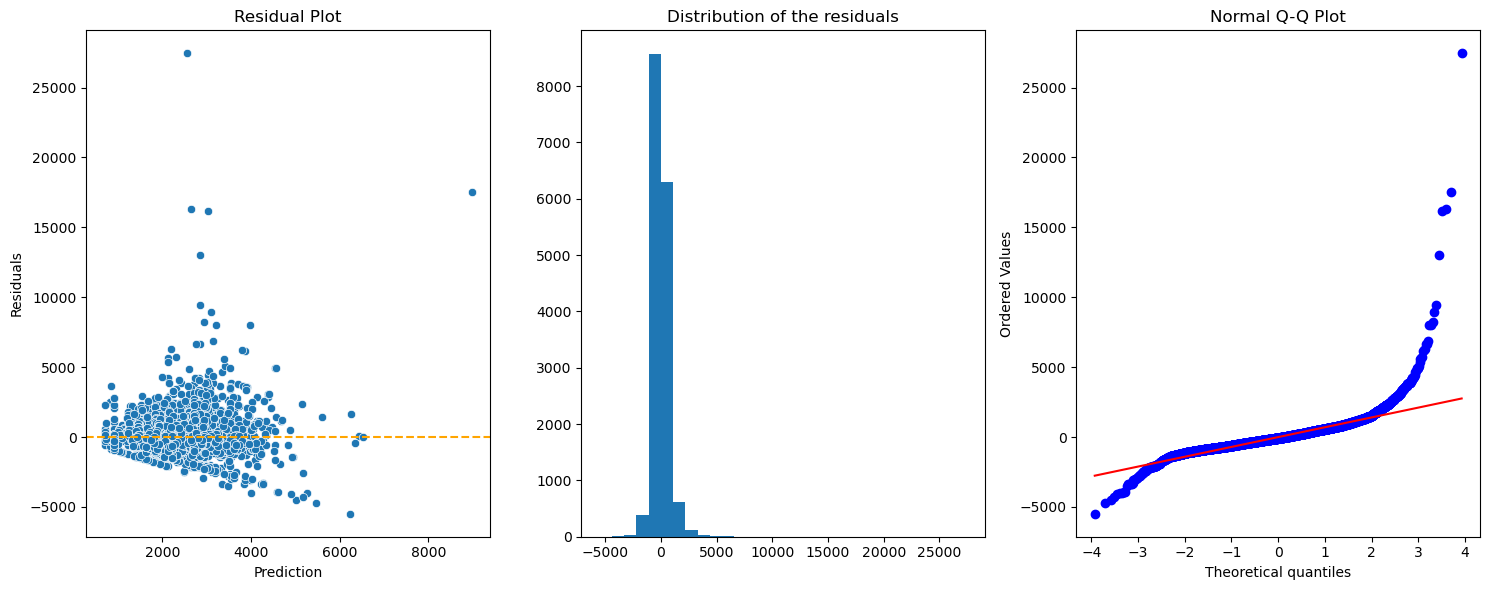

In [17]:
# Plot residuals
residual_analysis_plots(model)

**Observations**

The residuals do not seem to be independent and normally distributed. Looking at the Q-Q Plot, we can also see that there are a lot of outliers, especially for the higher prices.

### 1.2 With scaling

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Fit the model
X_constant = sm.add_constant(X_train_scaled)
model_scaled = sm.OLS(y_train, X_constant).fit()
model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     1337.
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:51:38   Log-Likelihood:            -1.3040e+05
No. Observations:               16104   AIC:                         2.608e+05
Df Residuals:                   16098   BIC:                         2.609e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2156.8016      6.267    344.163      0.000    2144.518    2169.085
x1            77.2616      7.132     10.833      0.000      63.282      91.241
x2           187.7031      8.909     21.068      0.000     170.240     205.166
x3           333.1869      8.781     37.942      0.000     315.974     350.400
x4           121.6451      8.115     14.991      0.000     105.739     137.551
x5           269.7446      7.814     34.519      0.000     254.428     285.061
==============================================================================
Omnibus:                    19253.694   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12700491.415
Skew:                           5.737   Prob(JB):                         0.00
Kurtosis:                     140.099   Cond. No.                         2.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test_scaled)
y_pred = model_scaled.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,500.2829,500.2829,0.0
1,MSE,523194.6194,523194.6194,0.0
2,RMSE,723.3219,723.3219,0.0
3,Test Mean,2157.2931,2157.2931,0.0
4,Predictions Mean,2154.3472,2154.3472,0.0
5,RMSE to mean ratio,0.3353,0.3353,0.0


### 1.3 Transforming y

In [24]:
y_log = np.log(y_train)
y_log = y_log.rename('log(price)')
X_constant = sm.add_constant(X_train)
model_log = sm.OLS(y_log, X_constant).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     1111.
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:51:38   Log-Likelihood:                -7600.4
No. Observations:               16104   AIC:                         1.521e+04
Df Residuals:                   16098   BIC:                         1.526e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.8522      0.013    512.177      0.000       6.826       6.878
city            2.258e-05   1.95e-06     11.574      0.000    1.88e-05    2.64e-05
beds               0.1415      0.004     31.724      0.000       0.133       0.150
baths              0.2315      0.007     34.342      0.000       0.218       0.245
sq_feet         -6.45e-05   8.15e-06     -7.915      0.000   -8.05e-05   -4.85e-05
type_Apartment     0.2833      0.008     34.070      0.000       0.267       0.300
==============================================================================
Omnibus:                    15239.307   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2202732.358
Skew:                          -4.147   Prob(JB):                         0.00
Kurtosis:                      59.692   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_log_test = np.log(y_test)
y_pred = model_log.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_log_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,500.2829,0.2477,-500.0352
1,MSE,523194.6194,0.1406,-523194.4788
2,RMSE,723.3219,0.3749,-722.9470
3,Test Mean,2157.2931,7.5985,-2149.6946
4,Predictions Mean,2154.3472,7.5939,-2146.7533
5,RMSE to mean ratio,0.3353,0.0493,-0.2860


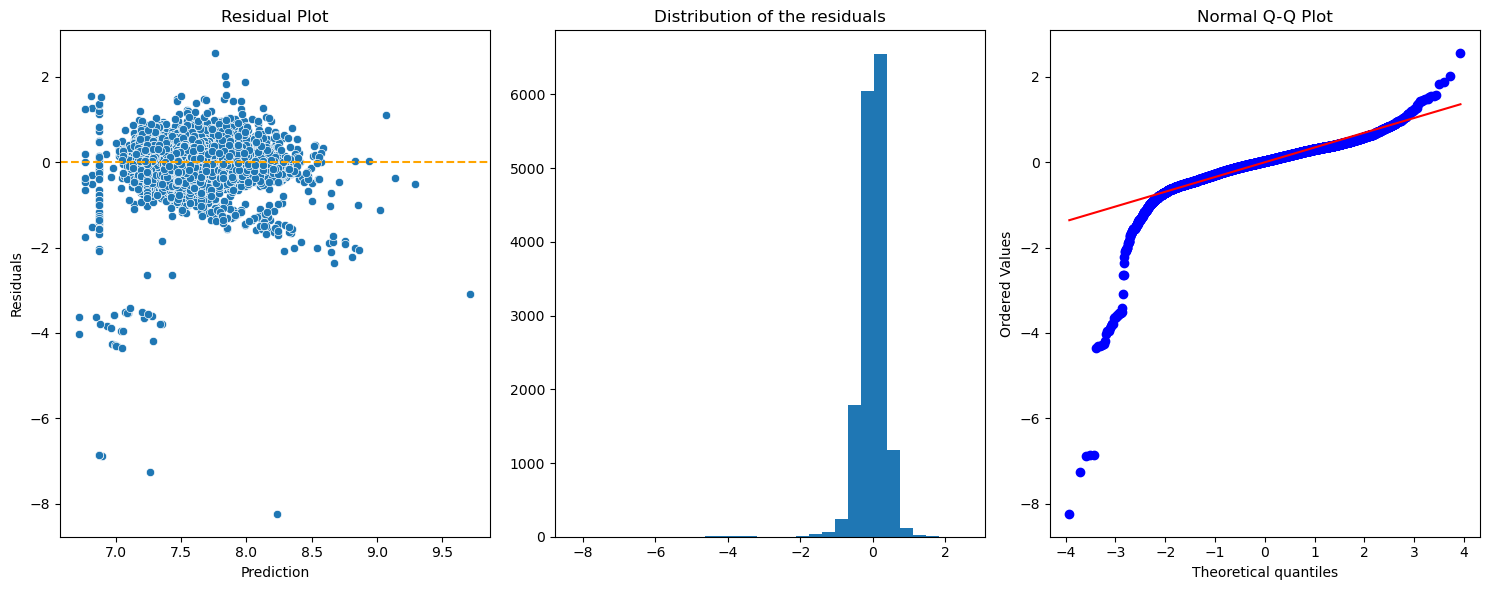

In [26]:
# Plot residuals
residual_analysis_plots(model_log)

Transforming the target variable decreases our model performance in terms of R-squared, but improves the relative RMSE. Our model is still not performing well.

### 1.4 Assess multicollinearity

In [29]:
vif_scores = pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)
vif_scores

city               2.298864
beds               7.952959
baths             10.439918
sq_feet            7.024752
type_Apartment     1.886882
dtype: float64

In [30]:
# Remove problematic features
columns_to_keep = list(vif_scores[vif_scores <= 5].index)

In [31]:
# Re-fit model
X_train_vif = X_train[columns_to_keep]
X_test_vif = X_test[columns_to_keep]
X_constant = sm.add_constant(X_train_vif)
model_vif = sm.OLS(y_train, X_constant).fit()
model_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     44.42
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           5.76e-20
Time:                        17:51:39   Log-Likelihood:            -1.3315e+05
No. Observations:               16104   AIC:                         2.663e+05
Df Residuals:                   16101   BIC:                         2.663e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2014.9022     20.801     96.867      0.000    1974.130    2055.674
city               0.0444      0.005      9.408      0.000       0.035       0.054
type_Apartment    72.1289     18.379      3.925      0.000      36.105     108.153
==============================================================================
Omnibus:                    17831.435   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6378469.645
Skew:                           5.151   Prob(JB):                         0.00
Kurtosis:                      99.953   Cond. No.                     9.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test_vif)
y_pred = model_vif.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,500.2829,615.2465,114.9636
1,MSE,523194.6194,750300.3767,227105.7573
2,RMSE,723.3219,866.1988,142.8769
3,Test Mean,2157.2931,2157.2931,0.0000
4,Predictions Mean,2154.3472,2155.1944,0.8472
5,RMSE to mean ratio,0.3353,0.4015,0.0662


Based on the R-squared, the performance of the model is much worse now. It's not a good idea to remove those features.

### 1.5 Assess outliers

In [35]:
# Get list of Cook's Distances
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
cook_d = inf_summary_df["cooks_d"]
cook_d.nlargest(n=20).round(4)

1980     3.2100
18103    0.1786
5815     0.0850
16501    0.0823
4120     0.0599
5663     0.0592
825      0.0404
6326     0.0313
18104    0.0276
1153     0.0265
8954     0.0255
17381    0.0223
15284    0.0214
209      0.0213
9580     0.0171
3661     0.0155
4055     0.0154
7103     0.0133
15283    0.0113
1156     0.0101
Name: cooks_d, dtype: float64

In [36]:
# There is one problematic row, let's print the full data
outliers = cook_d[cook_d > 0.5].index
unprocessed_df = pd.read_pickle('../Data/cleaned_data.pkl')
unprocessed_df.iloc[outliers]

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
1980,490755,Calgary,Alberta,Springbank Hill,51.028096,-114.19508,Negotiable,House,26500.0,8,7.5,11700.0,/ab/calgary/rentals/house/8-bedrooms/springban...,Unfurnished,Immediate,Non-Smoking,True,True


In [37]:
# Remove outlier
df = df.drop(outliers).reset_index(drop=True)

In [38]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [40]:
# Fit model
X_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     1379.
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:53:46   Log-Likelihood:            -1.2963e+05
No. Observations:               16104   AIC:                         2.593e+05
Df Residuals:                   16098   BIC:                         2.593e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            413.9236     26.377     15.693      0.000     362.222     465.625
city               0.0409      0.004     10.740      0.000       0.033       0.048
beds             199.9230      8.732     22.897      0.000     182.808     217.038
baths            514.2872     13.142     39.132      0.000     488.527     540.048
sq_feet            0.2180      0.016     13.483      0.000       0.186       0.250
type_Apartment   576.0879     16.268     35.413      0.000     544.201     607.975
==============================================================================
Omnibus:                    13026.438   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1413978.523
Skew:                           3.247   Prob(JB):                         0.00
Kurtosis:                      48.443   Cond. No.                     1.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,500.2829,509.6893,9.4064
1,MSE,523194.6194,739447.4598,216252.8404
2,RMSE,723.3219,859.9113,136.5894
3,Test Mean,2157.2931,2173.3291,16.0360
4,Predictions Mean,2154.3472,2153.7757,-0.5715
5,RMSE to mean ratio,0.3353,0.3957,0.0604


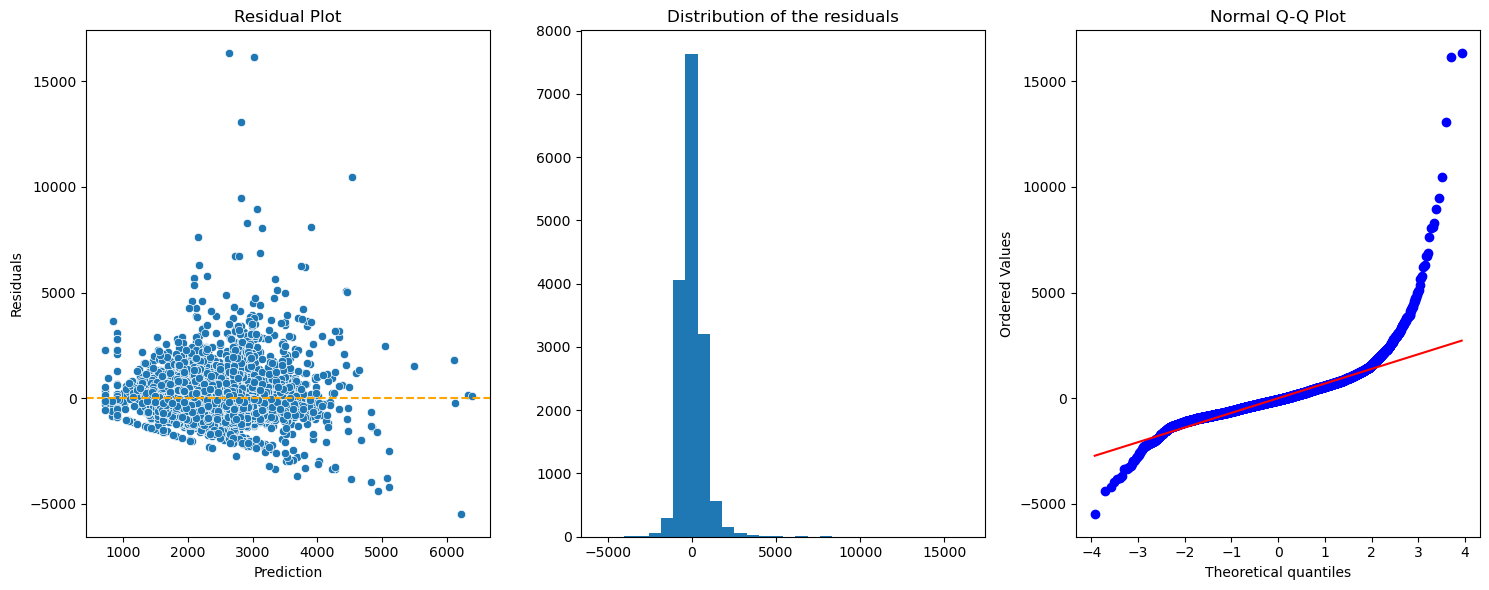

In [42]:
# Plot residuals
residual_analysis_plots(model)

The R-squared is slightly better but the metrics are worse, which indicates our model is not good. Also, the residuals are still not normally distributed.

## 2. Second regression model (polynomial regression)

There seems to be non-linear relationships between variables. Let's see if we can obtain better performance with a different polynomial degree.

In [46]:
# Find the optimal degree

train_rmse_errors = []
test_rmse_errors = []
degrees = []

for d in range(1, 11):
    polynomial_converter = PolynomialFeatures(degree=d, include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.15, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))
    
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)
    degrees.append(d)

In [47]:
# Print results

results_df = pd.DataFrame({
    'Degree': degrees,
    'Train RMSE': train_rmse_errors,
    'Test RMSE': test_rmse_errors,
})

results_df

,Degree,Train RMSE,Test RMSE
0,1,757.938737,8.599113e+02
1,2,736.825837,8.436132e+02
2,3,718.671634,8.609874e+02
3,4,686.639664,8.803407e+02
4,5,634.313467,1.210735e+03
5,6,599.293717,4.458552e+04
6,7,563.610378,1.290069e+06
7,8,544.233278,1.342090e+07
8,9,526.410748,1.601632e+11
9,10,522.107968,6.450976e+11


The best degree is 2. The RMSE starts to increase at 3.

In [49]:
# Create poly features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.15, random_state=42)

In [50]:
# Fit model
X_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     432.7
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:54:47   Log-Likelihood:            -1.2917e+05
No. Observations:               16104   AIC:                         2.584e+05
Df Residuals:                   16084   BIC:                         2.585e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1001.6165     71.532     14.002      0.000     861.406    1141.827
city                       0.1214      0.019      6.406      0.000       0.084       0.159
beds                     348.3894     35.556      9.798      0.000     278.695     418.084
baths                    325.7171     56.468      5.768      0.000     215.033     436.401
sq_feet                   -0.4001      0.055     -7.303      0.000      -0.508      -0.293
type_Apartment           -71.2433     28.768     -2.476      0.013    -127.632     -14.855
city^2                 -2.612e-05   2.63e-06     -9.941      0.000   -3.13e-05    -2.1e-05
city beds                 -0.0044      0.006     -0.776      0.438      -0.016       0.007
city baths                 0.0248      0.008      3.089      0.002       0.009       0.041
city sq_feet            4.131e-06    9.9e-06      0.417      0.677   -1.53e-05    2.35e-05
city type_Apartment        0.0057      0.009      0.642      0.521      -0.012       0.023
beds^2                   -68.3301      6.527    -10.468      0.000     -81.124     -55.536
beds baths                 1.4227     13.949      0.102      0.919     -25.918      28.763
beds sq_feet               0.1271      0.018      7.181      0.000       0.092       0.162
beds type_Apartment      -24.7437     23.225     -1.065      0.287     -70.266      20.779
baths^2                  -86.0517     12.538     -6.863      0.000    -110.627     -61.477
baths sq_feet              0.2227      0.028      7.994      0.000       0.168       0.277
baths type_Apartment     318.4704     32.811      9.706      0.000     254.157     382.784
sq_feet^2               -2.24e-05   7.57e-06     -2.958      0.003   -3.73e-05   -7.56e-06
sq_feet type_Apartment     0.2247      0.040      5.614      0.000       0.146       0.303
type_Apartment^2         -71.2433     28.768     -2.476      0.013    -127.632     -14.855
==============================================================================
Omnibus:                    13170.266   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1478616.119
Skew:                           3.297   Prob(JB):                         0.00
Kurtosis:                      49.477   Cond. No.                     2.01e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.69e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Observations**

The R-squared went from from 0.293 to 0.338, which is a good improvement.
The Durbin-Watson score of 1.983 indicates that the errors might be independent

In [52]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,500.2829,495.1130,-5.1699
1,MSE,523194.6194,711683.1491,188488.5297
2,RMSE,723.3219,843.6132,120.2913
3,Test Mean,2157.2931,2173.3291,16.0360
4,Predictions Mean,2154.3472,2152.4251,-1.9221
5,RMSE to mean ratio,0.3353,0.3882,0.0529


The performance of the model has not improved.

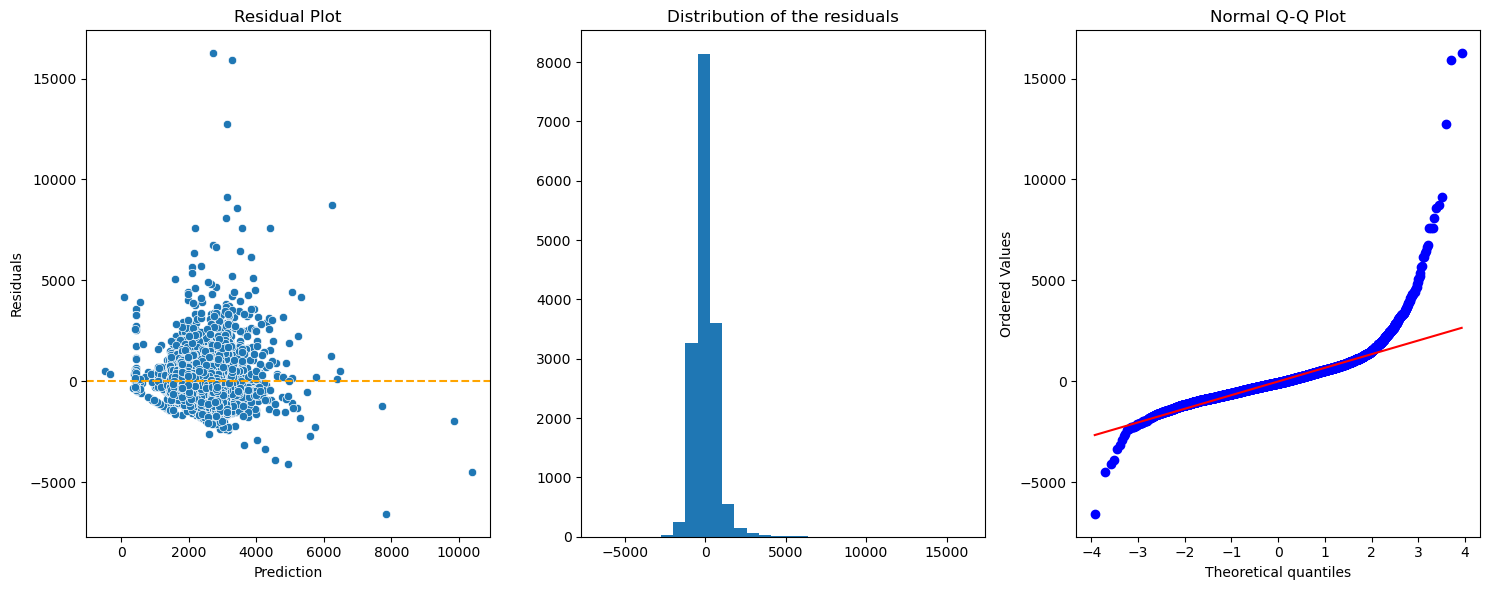

In [54]:
# Plot residuals
residual_analysis_plots(model)

The residuals don't seem to be independant and normally distributed. There are still outliers if we look at the Q-Q Plot, especially the higher prices.

In [56]:
# Re-fit model without the statistically unsignificant variables (95% confidence interval)
features = list(model.pvalues[model.pvalues <= 0.05].index)[1:] # remove constant from result
X_train = X_train[features]
X_test = X_test[features]

X_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     587.3
Date:                Fri, 31 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:54:48   Log-Likelihood:            -1.2918e+05
No. Observations:               16104   AIC:                         2.584e+05
Df Residuals:                   16089   BIC:                         2.585e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    989.8419     60.390     16.391      0.000     871.471    1108.213
city                       0.1291      0.014      9.355      0.000       0.102       0.156
beds                     316.5621     19.651     16.109      0.000     278.044     355.081
baths                    356.1661     47.056      7.569      0.000     263.931     448.401
sq_feet                   -0.3874      0.045     -8.624      0.000      -0.475      -0.299
type_Apartment           -66.5871     23.620     -2.819      0.005    -112.885     -20.289
city^2                 -2.663e-05   2.53e-06    -10.515      0.000   -3.16e-05   -2.17e-05
city baths                 0.0210      0.006      3.782      0.000       0.010       0.032
beds^2                   -66.4323      4.734    -14.032      0.000     -75.712     -57.152
beds sq_feet               0.1293      0.017      7.424      0.000       0.095       0.163
baths^2                  -87.7350     11.423     -7.681      0.000    -110.125     -65.345
baths sq_feet              0.2219      0.027      8.203      0.000       0.169       0.275
baths type_Apartment     298.9441     26.360     11.341      0.000     247.275     350.613
sq_feet^2              -2.275e-05   7.43e-06     -3.062      0.002   -3.73e-05   -8.19e-06
sq_feet type_Apartment     0.2124      0.035      6.043      0.000       0.144       0.281
type_Apartment^2         -66.5871     23.620     -2.819      0.005    -112.885     -20.289
==============================================================================
Omnibus:                    13172.791   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1479998.709
Skew:                           3.298   Prob(JB):                         0.00
Kurtosis:                      49.499   Cond. No.                     1.19e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.53e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [57]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,500.2829,494.9830,-5.2999
1,MSE,523194.6194,711863.2646,188668.6452
2,RMSE,723.3219,843.7199,120.3980
3,Test Mean,2157.2931,2173.3291,16.0360
4,Predictions Mean,2154.3472,2152.5690,-1.7782
5,RMSE to mean ratio,0.3353,0.3882,0.0529


The performance of the model has not really improved.

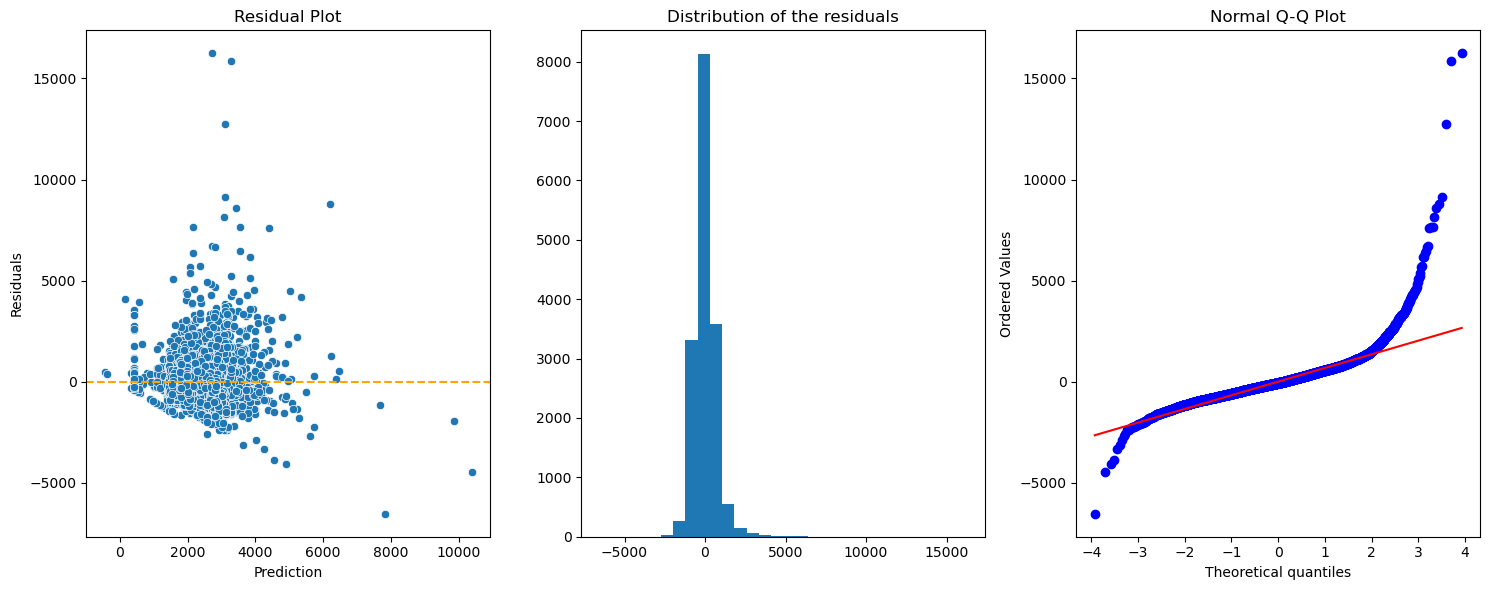

In [59]:
# Plot residuals
residual_analysis_plots(model)

The residuals are still not normally distributed and there are still outliers.

## 3. Third model (regularization, cross-validation and grid search)

## End